In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

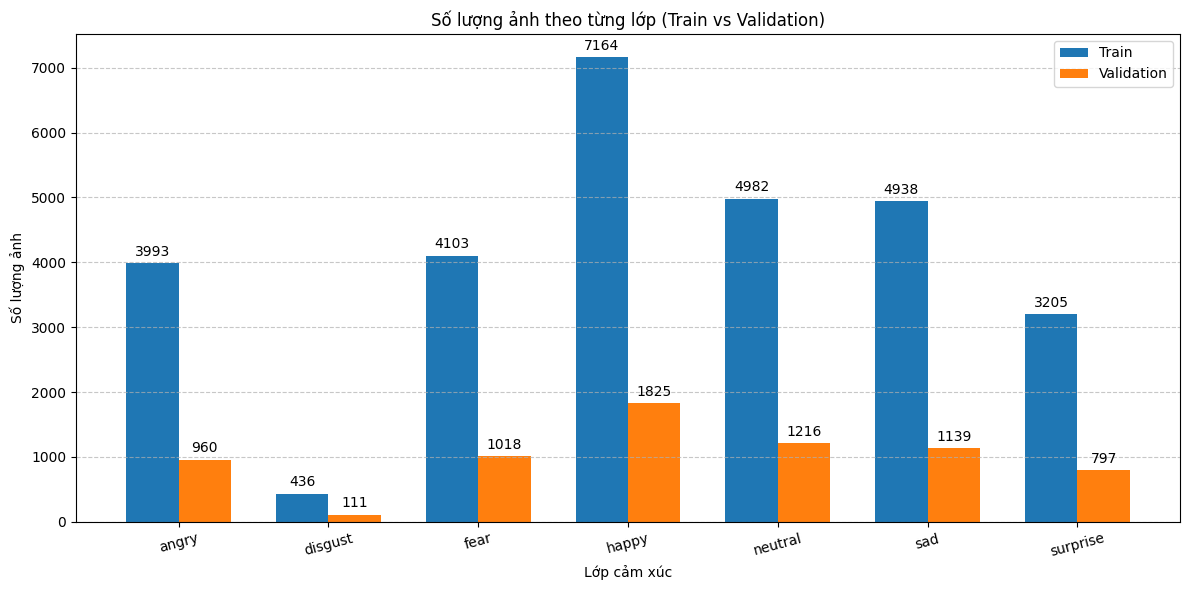

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn
train_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/train'
val_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/validation'

# Lấy danh sách lớp
classes = os.listdir(train_dir)
train_counts = []
val_counts = []

# Đếm ảnh
for cls in classes:
    train_path = os.path.join(train_dir, cls)
    val_path = os.path.join(val_dir, cls)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    val_count = len(os.listdir(val_path)) if os.path.exists(val_path) else 0

    train_counts.append(train_count)
    val_counts.append(val_count)

# Vẽ biểu đồ
x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

ax.set_ylabel('Số lượng ảnh')
ax.set_xlabel('Lớp cảm xúc')
ax.set_title('Số lượng ảnh theo từng lớp (Train vs Validation)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=15)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị số lượng trên đầu mỗi cột
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 điểm pixel lên trên
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [3]:
emotion_labels = sorted(os.listdir(train_dir))
print("Các thư mục nhãn có trong train_dir:")
print(emotion_labels)

for label in emotion_labels:
    label_path = os.path.join(train_dir, label)
    print(f"{label}: {len(os.listdir(label_path))} ảnh")

Các thư mục nhãn có trong train_dir:
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
angry: 3993 ảnh
disgust: 436 ảnh
fear: 4103 ảnh
happy: 7164 ảnh
neutral: 4982 ảnh
sad: 4938 ảnh
surprise: 3205 ảnh


In [4]:
# Cấu hình
IMG_SIZE = (224, 224)
BATCH_SIZE = 32



train_datagen = ImageDataGenerator(
        rescale = 1.0/255.0,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        rotation_range = 20,
        horizontal_flip = True
    )

validation_datagen = ImageDataGenerator(
    rescale= 1.0/255
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Chỉnh sửa kích thước ảnh thành 224x224
    color_mode="rgb",  # Chuyển đổi ảnh từ grayscale sang RGB (3 kênh)
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Chỉnh sửa kích thước ảnh thành 224x224
    color_mode="rgb",  # Chuyển đổi ảnh từ grayscale sang RGB (3 kênh)
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [5]:
# Load base model ResNet50 (bỏ phần top)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze để chỉ huấn luyện tầng FC đầu tiên

# Thêm các tầng phân loại
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 1403s 776ms/step - accuracy: 0.2282 - loss: 1.8413 - val_accuracy: 0.2597 - val_loss: 1.7958
Epoch 2/50
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 1302s 722ms/step - accuracy: 0.2471 - loss: 1.8020 - val_accuracy: 0.1888 - val_loss: 1.8061
Epoch 3/50
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 1303s 723ms/step - accuracy: 0.2533 - loss: 1.7951 - val_accuracy: 0.2709 - val_loss: 1.7717
Epoch 4/50
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 1304s 723ms/step - accuracy: 0.2563 - loss: 1.7866 - val_accuracy: 0.2655 - val_loss: 1.7824
Epoch 5/50
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 1305s 724ms/step - accuracy: 0.2583 - loss: 1.7837 - val_accuracy: 0.2705 - val_loss: 1.7617
Epoch 6/50
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 1304s 724ms/step - accuracy: 0.2630 - loss: 1.7749 - val_accuracy: 0.2891 - val_loss: 1.7529
Epoch 7/50
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 1306s 725ms/step - accuracy: 0.2752 - loss: 1.7572 - val_accuracy: 0.2937 - val_loss: 1.7327
Epoch 8/50
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 1307s 725ms/s

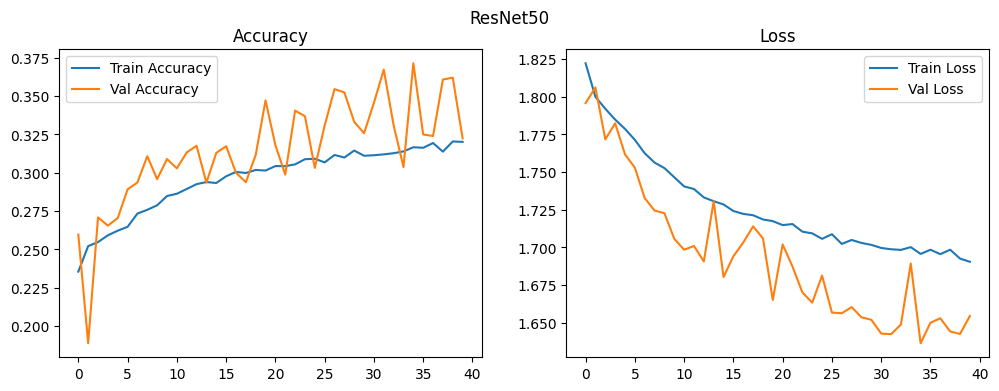

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Huấn luyện mô hình
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('emotion_model.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=validation_generator,  # Corrected here
    steps_per_epoch=len(train_generator),
    epochs=50,
    callbacks=callbacks
)

model.save('emotion_model_ResNet50.keras')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.suptitle("ResNet50")  # Tiêu đề cho toàn bộ figure
plt.show()